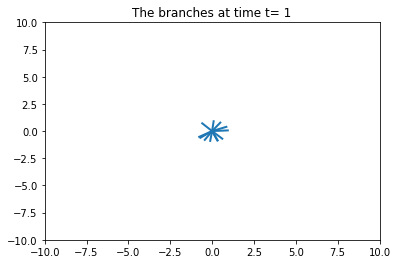

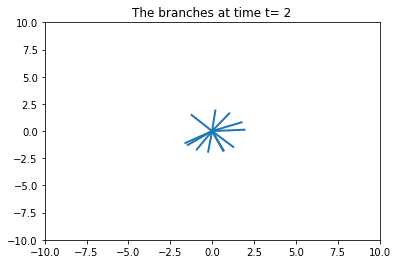

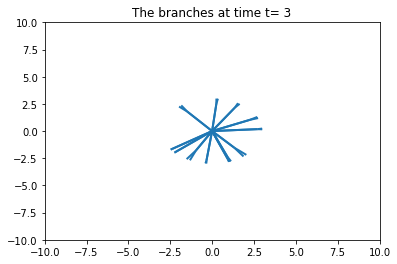

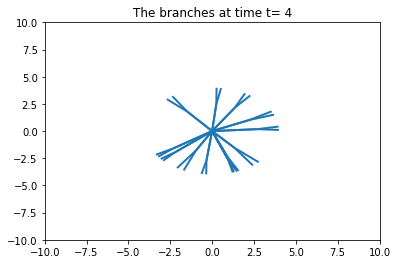

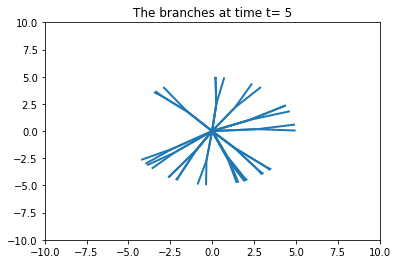

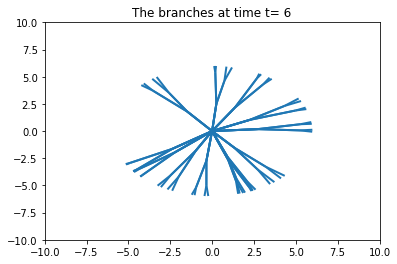

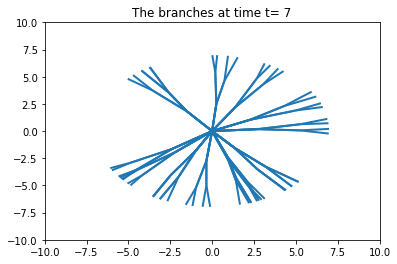

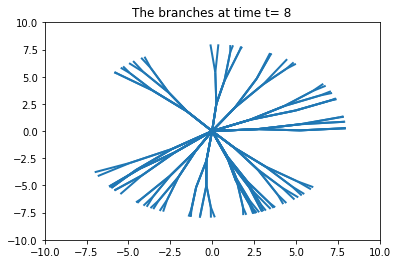

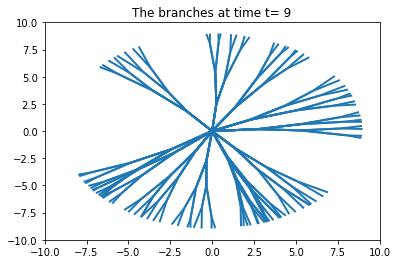

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 23 11:19:11 2019

@author: changxiwang
"""

# %% import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from matplotlib import collections  as mc
%matplotlib inline

# %% the function to prepare the nodes for only one tree
def nodes_of_a_tree(state,t):
    np.random.seed(state)
    n_g = 8
    t_array = np.zeros(shape=(n_g+1,2**(n_g+1)-1), dtype=float, order='F')
    #t_init = np.random.exponential(scale=4.0, size=1000)
    #t_init = np.random.uniform(2,3,10000)
    t_init = np.random.uniform(2,3,int((2**(n_g+2))))

    # %% randomly grow a full tree
    def gen_tree():
        #t_init = np.random.exponential(scale=3.0, size=1000)      
        n=2**(n_g+1)-1
        
        for i in range(1,n_g+1):
            for j in range(2**i):
                t_array[i,int((n-(2**i-1))*j/2**i+j):int((n-(2**i-1))*(j+1)/2**i)+j] = t_init[int((2**i+j)//2)]

        ct_array = np.cumsum(t_array,axis=0)    
        ict_array = t - ct_array

        ict_array[ict_array <= 0] = 0
        id_nonzero = np.nonzero(ict_array[n_g,:]!=0)
        
        ict2 = np.zeros((n_g+1,len(id_nonzero[0])))
        for x in range(len(id_nonzero[0])):
            ict2[:,x] = sum([],ict_array[:,id_nonzero[0][x]])
        ict2    
            
        branch_levels = []    
        for x in range(len(id_nonzero[0])):
            branch_levels.append(len(np.unique(ict2[:,x])))

        rtn_dat = [sorted(branch_levels),sum(ict_array[n_g,:]),ict2]
        return rtn_dat

    tree_data = gen_tree()
    trees = []
    trees.append(tree_data[2])


    # %% flatten the list of times of branches
    def tree_transform(trees):
        trees_unlist=reduce(lambda x,y: x+y,trees)
        return trees_unlist
    trees2=tree_transform(trees)

    # %% from full branches (including main paths) to only branches
    ext_lst=list(range(trees2.shape[1]))
    rem_lst=[]
    peels=[]

    while len(ext_lst)!=1:
        ext_copy=ext_lst.copy()
        for i in range(1,len(ext_lst)-1):
            if all(trees2[:,ext_lst[i-1]]==trees2[:,ext_lst[i+1]]):
                rem_lst.append(ext_lst[i])
                peels.extend([ext_lst[i-1],ext_lst[i+1]])
                ext_copy.remove(ext_lst[i-1])
                ext_copy.remove(ext_lst[i+1])
        ext_lst=ext_copy.copy()

    set_ext=set(range(trees2.shape[1]))
    set_rem=set(rem_lst)
    kept_lst=list(set_ext.difference(set_rem))
    Tree=trees2[:,kept_lst]

    # %% prepare drawing data sgement lengths
    T=-np.diff(Tree,axis=0)
    for i in range(T.shape[1]):
        if any(T[:,i]==0):
            id_zero=np.where(T[:,i]==0)[0][0]
            T[id_zero,i]=Tree[-1,i]
        else:
            continue

    # %% prepare drawing data angles 
    #theta_ini=list(np.random.uniform(0,360,10))
    theta=iter(np.random.uniform(10,15,10000))
    theta0=list(np.random.uniform(10,15,10000))
    theta1=[]
    for ele in theta0:
        theta1.extend([-ele/2,ele/2])

    T_f=T[~(T==0).all(1)]
    T_f=np.vstack((T_f,np.zeros((1,T_f.shape[1]))))
    angle=np.zeros((T_f.shape[0],T_f.shape[1]))

    # set up the first branch (shared by all paths)
    ang_ini=np.random.uniform(0,360,1)
    angle[0,:]=ang_ini

    for i in range(1,T_f.shape[0]):
        row_unique=list(set(T_f[i,:]))
        try:
            row_unique.remove(0)
        except ValueError:
            pass  # do nothing!

        for unique_value in row_unique:
            if  all((T_f[i+1,(T_f[i,:]==unique_value)]==0)) and sum(T_f[i,:]==unique_value)%2==0:
                the_pir=next(theta)
                angle[i,T_f[i,:]==unique_value]=np.array([the_pir/2,-the_pir/2])+np.array(angle[i-1,T_f[i,:]==unique_value])
            elif all((T_f[i+1,(T_f[i,:]==unique_value)]==0)) and sum(T_f[i,:]==unique_value)%2==1:
                theta_unq=next(theta)
                angle[i,T_f[i,:]==unique_value]=theta_unq/2*(-1)**i+np.array(angle[i-1,T_f[i,:]==unique_value])
            else:
                angle[i,T_f[i,:]==unique_value]=theta1.pop()+np.array(angle[i-1,T_f[i,:]==unique_value])

    # %% write a function to combine angle and segment length matrix to produce coordinates for drawing plotting
    x_cor=np.zeros((T_f.shape[0],T_f.shape[1]))
    y_cor=x_cor.copy()
    angle_a=angle/180*np.pi

    #  prepare nodes data
    for i in range(1,T_f.shape[0]):
        x_cor[i,:]=x_cor[i-1,:]+np.multiply(T_f[i-1,:],np.cos(angle_a[i-1,:]))
        y_cor[i,:]=y_cor[i-1,:]+np.multiply(T_f[i-1,:],np.sin(angle_a[i-1,:]))

    #  plot the line segments
    #  define a function to create list of coordiantes
    def cormat_to_list(x_cor,y_cor):
        pair_list=[]
        for  j in range(x_cor.shape[1]):
            tem=list(zip(x_cor[:,j],y_cor[:,j]))
            pair_list.append([[tem[i],tem[i+1]] for i in range(x_cor.shape[0]-1)])
        return reduce(lambda x,y: x+y,pair_list)
    nodes_one_tree=cormat_to_list(x_cor,y_cor)
    return nodes_one_tree



# %% write a overall function to drar the big pattern tree
def big_tree(n_trees,time):
    all_branches=[]
    for i in range(n_trees):
        one_tree_nodes=nodes_of_a_tree(state=i*2,t=time)# state is the seed of random state
        all_branches.extend(one_tree_nodes)
        #print(one_tree_nodes)
    return all_branches


# %% function to draw the big tree
def plot_branches_t(n_trees,t_iter):
    all_branches=big_tree(n_trees,time=t_iter)
    lc = mc.LineCollection(all_branches, linewidths=2)
    fig, ax = plt.subplots()
    lim=10
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.add_collection(lc)
    ax.margins(0.1)
    ax.set_title('The branches at time t= '+str(t_iter))
    plt.show()


# %% plot the branches up to time T=10
def branches_up_to_T(n_trees,T):
    for t_iter in range (1,T,1):
        plot_branches_t(n_trees,t_iter)

branches_up_to_T(12,10)

